# Time Series Forecasting

Predict the future behavior of a time series $z_i$ for item $i ∈ I$ given its past

Use that to make optimal decisions

Caveat

![](support/bohr.png)

Point forecasts are typically insufficient for decision making

Uncertainty is as important as the forecast

### Probabilistic Forecasting

What is the distribution of the future time series values?

<img src="support/probabilistic_forecast.png" width="600">

P50 Forecast: 50% of the time $z_t \leq \hat{z_t}$

P90 Forecast: 90% of the time $z_t \leq \hat{z_t}$

In [1]:
!pip install gluonts

In [2]:
import mxnet as mx
from mxnet import gluon
import gluonts as ts

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import json
import os
from itertools import islice
from pathlib import Path

mx.random.seed(0)
np.random.seed(0)

import warnings
warnings.filterwarnings("ignore")

## Time Series Datasets

In [3]:
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas


print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly']


In [4]:
dataset = get_dataset("m4_hourly")

INFO:root:using dataset already processed in path /Users/adesojia/.mxnet/gluon-ts/datasets/m4_hourly.


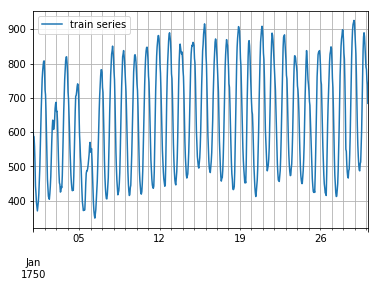

In [5]:
entry = next(iter(dataset.train))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

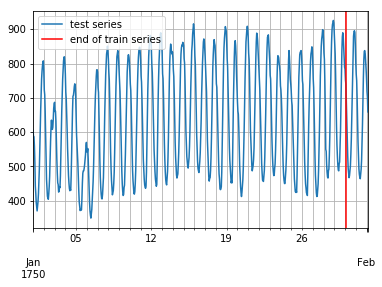

In [6]:
entry = next(iter(dataset.test))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

### Metadata

In [7]:
print(f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}")
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Length of forecasting window in test dataset: 48
Recommended prediction horizon: 48
Frequency of the time series: H


## Custom Time Series

The only requirements for a custom dataset are to be iterable and have a “target” and a “start” field

In [8]:
N = 10  # number of time series
T = 100  # number of timesteps
prediction_length = 24
freq = "1H"
custom_dataset = np.random.normal(size=(N, T))
start = pd.Timestamp("01-01-2019", freq=freq) 

In [9]:
from gluonts.dataset.common import ListDataset

In [10]:
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset([{'target': x, 'start': start}
                        for x in custom_dataset[:, :-prediction_length]],
                       freq=freq)

# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset([{'target': x, 'start': start}
                       for x in custom_dataset],
                      freq=freq)


In [11]:
def plot_time_series(train_series, test_series):

    fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

    train_series.plot(ax=ax[0])
    ax[0].grid(which="both")
    ax[0].legend(["train series"], loc="upper left")

    test_series.plot(ax=ax[1])
    ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
    ax[1].grid(which="both")
    ax[1].legend(["test series", "end of train series"], loc="upper left")

    plt.show()

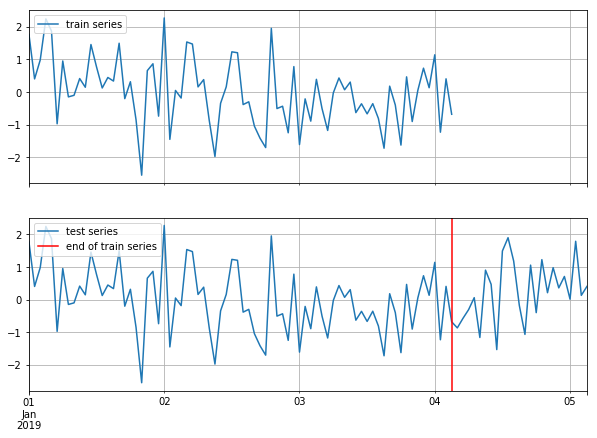

In [12]:
plot_time_series(to_pandas(next(iter(train_ds))), to_pandas(next(iter(test_ds))))

## Train an Existing Model

In [13]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.trainer import Trainer

INFO:root:Using CPU


### Load Estimator

In [14]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=dataset.metadata.prediction_length,
    context_length=100,
    freq=dataset.metadata.freq,
    trainer=Trainer(ctx="cpu",
                    epochs=5,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100
                   )
)

In [15]:
predictor = estimator.train(dataset.train)

INFO:root:Start model training
INFO:root:Number of parameters in SimpleFeedForwardTrainingNetwork: 483
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 121.37it/s, avg_epoch_loss=5.34]
INFO:root:Epoch[0] Elapsed time 0.826 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=5.335783
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 144.48it/s, avg_epoch_loss=4.88]
INFO:root:Epoch[1] Elapsed time 0.694 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=4.875309
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 164.50it/s, avg_epoch_loss=4.74]
INFO:root:Epoch[2] Elapsed time 0.610 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=4.736620
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 142.16it/s, avg_epoch_loss=4.72]
INFO:root:Epoch[3] Elapsed time 0.705 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=4.724447
INFO:root:Epoch[4] Le

## Evaluate Model

In [16]:
from gluonts.evaluation.backtest import make_evaluation_predictions

In [17]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_eval_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

In [18]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

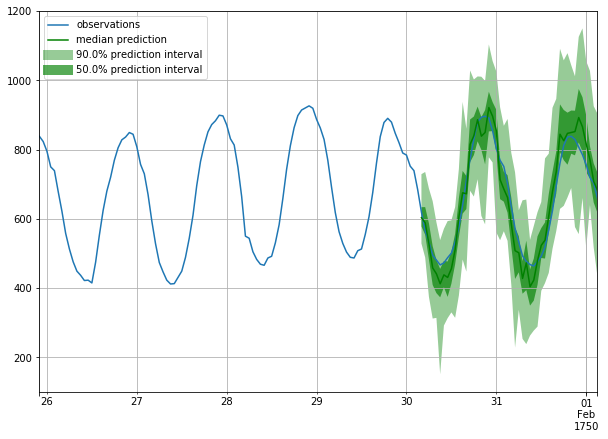

In [19]:
plot_prob_forecasts(tss[0], forecasts[0])

## Compute Metrics

In [20]:
from gluonts.evaluation import Evaluator

In [21]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))

Running evaluation: 100%|██████████| 414/414 [00:02<00:00, 198.30it/s]


In [22]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 7697386.850005422,
    "abs_error": 8638448.475698471,
    "abs_target_sum": 145558863.59960938,
    "abs_target_mean": 7324.822041043147,
    "seasonal_error": 336.9046924038302,
    "MASE": 4.184500530254321,
    "sMAPE": 0.20577636026331508,
    "MSIS": 36.86617444756125,
    "QuantileLoss[0.1]": 6147898.885920049,
    "Coverage[0.1]": 0.07779790660225441,
    "QuantileLoss[0.5]": 8638448.543136597,
    "Coverage[0.5]": 0.33876811594202894,
    "QuantileLoss[0.9]": 6044157.441540716,
    "Coverage[0.9]": 0.8611614331723031,
    "RMSE": 2774.4164882016944,
    "NRMSE": 0.37876913222680597,
    "ND": 0.05934677052343828,
    "wQuantileLoss[0.1]": 0.04223651335195329,
    "wQuantileLoss[0.5]": 0.05934677098674312,
    "wQuantileLoss[0.9]": 0.041523802069288324,
    "mean_wQuantileLoss": 0.04770236213599491,
    "MAE_Coverage": 0.0740908480944712
}


## RNN Model

In [23]:
from gluonts.model.canonical._estimator import CanonicalRNNEstimator

INFO:root:Using CPU
INFO:root:Using CPU
INFO:root:Using CPU


In [24]:
estimator = CanonicalRNNEstimator(prediction_length=dataset.metadata.prediction_length,
                                  num_cells=25,
                                  num_layers=2,
                                  context_length=100,
                                  freq=dataset.metadata.freq, 
                                  trainer=Trainer(epochs=5))

INFO:root:Using CPU


In [25]:
predictor = estimator.train(dataset.train)

INFO:root:Start model training
INFO:root:Number of parameters in CanonicalTrainingNetwork: 7913
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 29.65it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[0] Elapsed time 1.691 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=6.205568
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 33.52it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[1] Elapsed time 1.494 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=5.736433
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 31.85it/s, avg_epoch_loss=5.68]
INFO:root:Epoch[2] Elapsed time 1.572 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=5.684330
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 30.52it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[3] Elapsed time 1.640 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=5.584262
INFO:root:Epoch[4] Learning rate is 0.00

In [26]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_eval_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

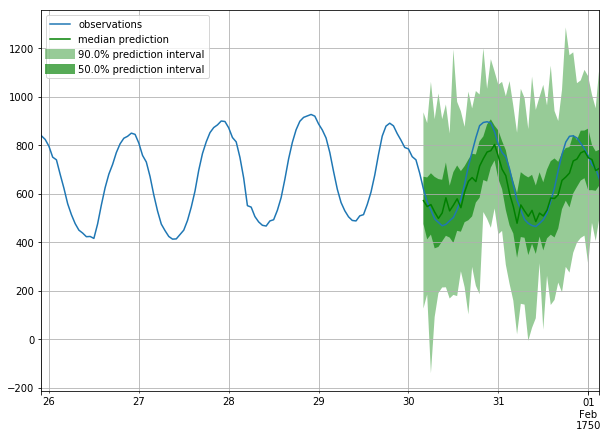

In [27]:
plot_prob_forecasts(tss[0], forecasts[0])

## Attention based model

In [28]:
from gluonts.model.transformer import TransformerEstimator

INFO:root:Using CPU


In [29]:
estimator = TransformerEstimator(prediction_length=dataset.metadata.prediction_length,
                                 model_dim=4,
                                 inner_ff_dim_scale=1,
                                 num_heads=2,
                                 freq=dataset.metadata.freq, 
                                 trainer=Trainer(epochs=5))

INFO:root:Using CPU


In [30]:
predictor = estimator.train(dataset.train)

INFO:root:Start model training
INFO:root:Number of parameters in TransformerTrainingNetwork: 95
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:02<00:00, 18.23it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[0] Elapsed time 2.745 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=5.751133
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:02<00:00, 18.43it/s, avg_epoch_loss=5.68]
INFO:root:Epoch[1] Elapsed time 2.715 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=5.683509
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:02<00:00, 18.33it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[2] Elapsed time 2.729 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=5.350524
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:02<00:00, 19.53it/s, avg_epoch_loss=4.85]
INFO:root:Epoch[3] Elapsed time 2.563 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=4.849458
INFO:root:Epoch[4] Learning rate is 0.00

In [31]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_eval_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

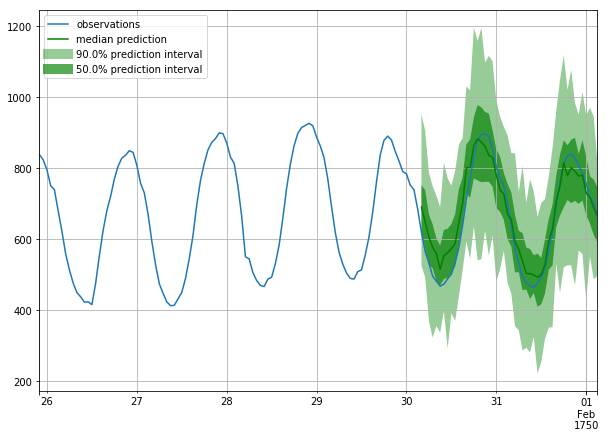

In [32]:
plot_prob_forecasts(tss[0], forecasts[0])

## DeepAR

In [33]:
from gluonts.model.deepar import DeepAREstimator

INFO:root:Using CPU


In [34]:
estimator = DeepAREstimator(prediction_length=dataset.metadata.prediction_length,
                            freq=dataset.metadata.freq, 
                            trainer=Trainer(epochs=5))

INFO:root:Using CPU


<img src="support/deep_ar.png" width="600">

In [35]:
predictor = estimator.train(dataset.train)

INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 10.76it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[0] Elapsed time 4.649 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=5.432816
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 10.06it/s, avg_epoch_loss=4.48]
INFO:root:Epoch[1] Elapsed time 4.972 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=4.478578
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 10.13it/s, avg_epoch_loss=4.44]
INFO:root:Epoch[2] Elapsed time 4.939 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=4.439733
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.24it/s, avg_epoch_loss=3.96]
INFO:root:Epoch[3] Elapsed time 4.451 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=3.961435
INFO:root:Epoch[4] Learning rate is 0.001


In [36]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_eval_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

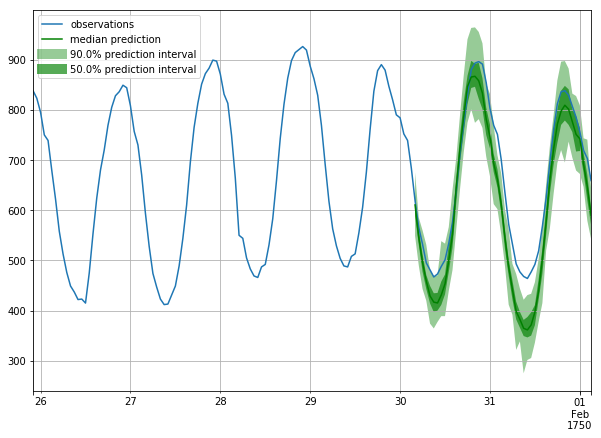

In [37]:
plot_prob_forecasts(tss[0], forecasts[0])

## Anomaly Detection with DeepAR

In [38]:
from itertools import islice
from gluonts.dataset.loader import TrainDataLoader
from gluonts.support.util import get_hybrid_forward_input_names

In [39]:
dataset = get_dataset(dataset_name="electricity")

estimator = DeepAREstimator(
    prediction_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
    trainer=Trainer(
        learning_rate=1e-3, epochs=50, num_batches_per_epoch=100
    ),
)

# instead of calling `train` method, we call `train_model` that returns more things including the training model
train_output = estimator.train_model(dataset.train)

INFO:root:using dataset already processed in path /Users/adesojia/.mxnet/gluon-ts/datasets/electricity.
INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:18<00:00,  5.31it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[0] Elapsed time 18.843 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=6.038154
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:18<00:00,  5.43it/s, avg_epoch_loss=5.61]
INFO:root:Epoch[1] Elapsed time 18.424 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=5.614266
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:18<00:00,  5.35it/s, avg_epoch_loss=5.51]
INFO:root:Epoch[2] Elapsed time 18.686 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=5.506517
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:18<00:00,  5.44it/s, avg_epoch_loss=5.4]
INFO:root:Epo

INFO:root:Epoch[36] Learning rate is 0.0005
100%|██████████| 100/100 [00:17<00:00,  5.65it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[36] Elapsed time 17.712 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=5.120657
INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 100/100 [00:18<00:00,  5.44it/s, avg_epoch_loss=5.14]
INFO:root:Epoch[37] Elapsed time 18.374 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.135620
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:17<00:00,  5.59it/s, avg_epoch_loss=5.14]
INFO:root:Epoch[38] Elapsed time 17.905 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.136082
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:17<00:00,  5.72it/s, avg_epoch_loss=5.1]
INFO:root:Epoch[39] Elapsed time 17.476 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.097945
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:17<00:00,  5.72it/s, avg_epoch_loss=

In [40]:
# we construct a data_entry that contains 500 random windows
batch_size = 500
num_samples = 100
training_data_loader = TrainDataLoader(
    dataset=dataset.train,
    transform=train_output.transformation,
    batch_size=batch_size,
    num_batches_per_epoch=estimator.trainer.num_batches_per_epoch,
    ctx=mx.cpu(),
)

for data_entry in islice(training_data_loader, 1):
    pass

In [41]:
# we now call the train model to get the predicted distribution on each window
# this allows us to investigate where are the biggest anomalies
context_length = train_output.trained_net.context_length
prediction_length = train_output.trained_net.prediction_length

input_names = get_hybrid_forward_input_names(train_output.trained_net)

distr = train_output.trained_net.distribution(
    *[data_entry[k] for k in input_names]
)

In [42]:
# gets all information into numpy array for further plotting
samples = distr.sample(num_samples).asnumpy()
percentiles = np.percentile(samples, axis=0, q=[10.0, 90.0])
target = mx.ndarray.concat(
    data_entry["past_target"], data_entry["future_target"], dim=1
)
target = target[:, -(context_length + prediction_length) :]
nll = -distr.log_prob(target).asnumpy()
target = target.asnumpy()
mean = samples.mean(axis=0)
percentiles = np.percentile(samples, axis=0, q=[10.0, 90.0])

In [43]:
def plot_anomalies(k, context_length, prediction_length, percentiles, target, nll):
    i = k // nll.shape[1]
    t = k % nll.shape[1]
    

    time_index = pd.date_range(
        pd.Timestamp(data_entry["forecast_start"][i]) - context_length,
        periods=context_length + prediction_length,
    )

    plt.figure(figsize=(10, 4))
    plt.fill_between(
        time_index,
        percentiles[0, i],
        percentiles[-1, i],
        alpha=0.5,
        label="80% CI predicted",
    )
    plt.plot(time_index, target[i], label="target")
    plt.axvline(time_index[t], alpha=0.5, color="r")
    plt.title(f"NLL: {nll[i, t]}")
    plt.legend()
    plt.show()

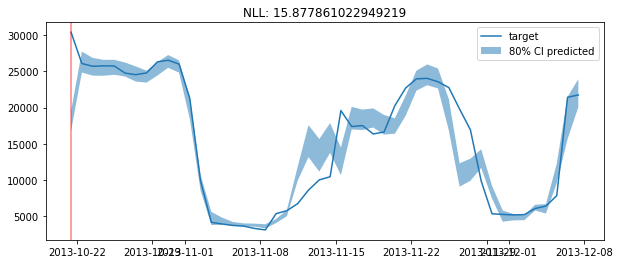

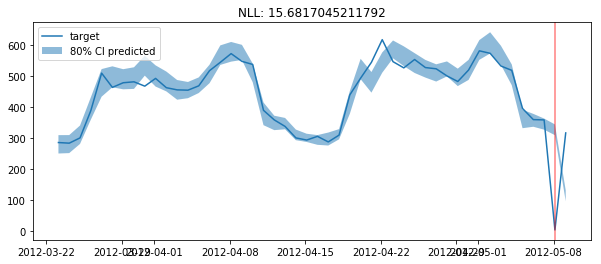

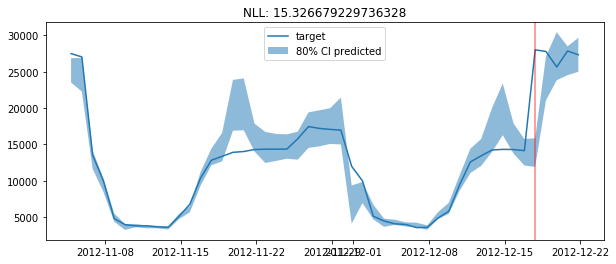

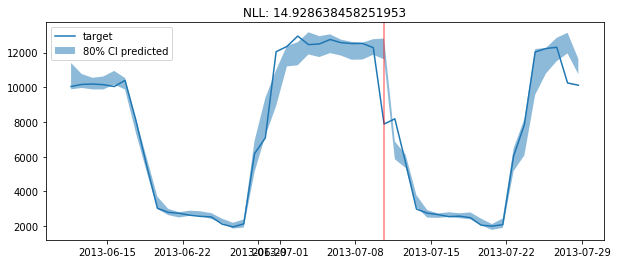

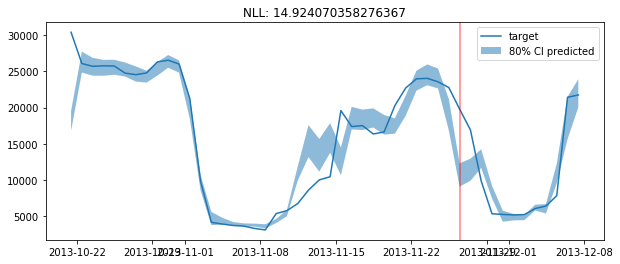

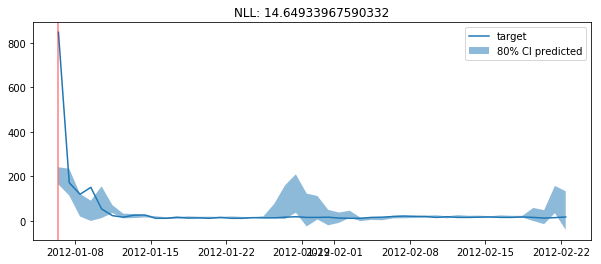

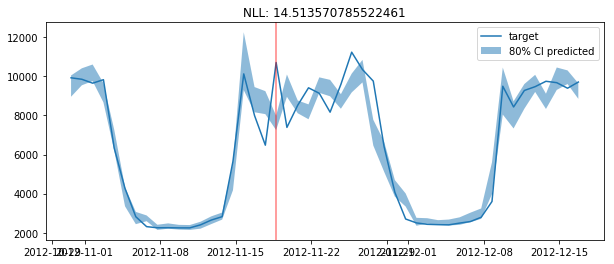

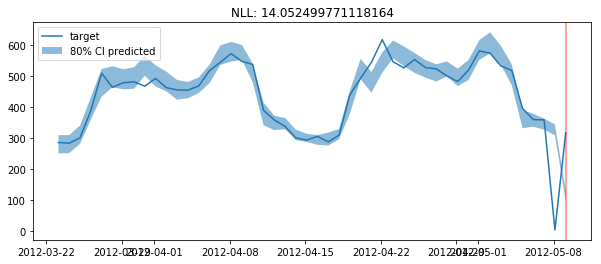

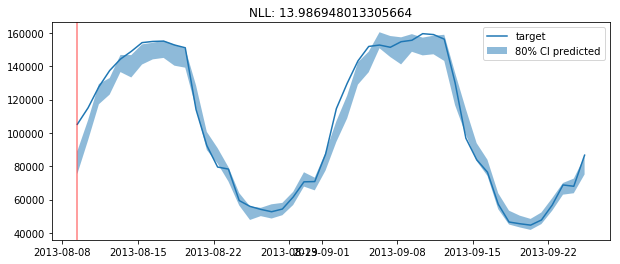

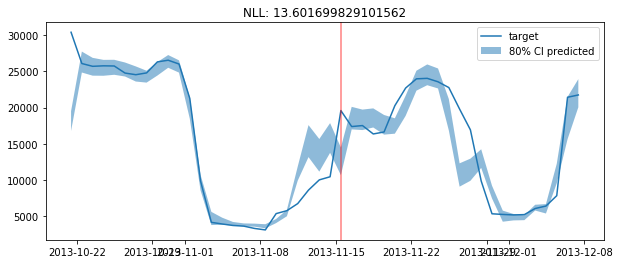

In [44]:
# NLL indices from largest to smallest
sorted_indices = np.argsort(nll.reshape(-1))[::-1]

# shows the series and times when the 20 largest NLL were observed
for k in sorted_indices[:10]:
    plot_anomalies(k, context_length, prediction_length, percentiles, target, nll)